# Linear Regression and Coulomb's Law

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhysData/course/blob/main/docs/notebooks/elmag.ipynb)

If you're running this in Colab, make sure to save a copy of the notebook in Google Drive to save your changes.


**What is Coulomb's Law?**

Coulomb's law relates the force between two point charges.

$$ F = k \frac{q_1 q_2}{r^2} $$

where $F$ is the force (N), $q_1$ and $q_2$ are the magnitudes of the charges (C), $r$ is the distance between the charges (m),  $k$ is Coulomb's constant (~8.98 x 10^9 Nm^2/C^2).

How was it discovered?

**The aim of the notebook**

In this notebook, we are going to explore how data science can help us to more rigorously understand physical phenomena by using synthetic data with predefined noise parameters. This can help us test the robustness of our models without needing to collect experimental data as well as be able to better explain the predictions our models make in the real world.


## Simulating Data

Firstly, we're going to explore how we can use existing libraries to generate synthetic data. This is an easy way to explore how our models behave under uncertainty in our input data. In other words, we can generate synthetic data to model uncertainty that might arise in experiments and build our models in a way that is robust. We can also use this technique to get a better understanding of the laws we are simulating, particularly when exploring well known physical concepts (such as Coulomb's law).

The function `random_y_kx` will generate a tuple of numbers `x` and `y` with stochastic linear dependence of `y` on `x`. We're going to use this to model the force-distance relationship in Coulomb's law. We'll generate these samples from two normal distributions with respective mean and standard deviation and we're going to add a noise parameter to reflect the uncertainty in real world measurements.

In [ ]:
# If you're running this notebook, uncomment the code in this cell to install the required packages.
# ! pip install numpy
# ! pip install scikit-learn
# ! pip install matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
def random_y_kx(mean_x=0, sigma_x=1, mean_noise=0, sigma_noise=1, size=1):
    x = np.random.normal(mean_x, sigma_x, size)
    k = np.random.random()
    noise = np.random.normal(mean_noise, sigma_noise, size)
    y = k * x + noise
    return x, y

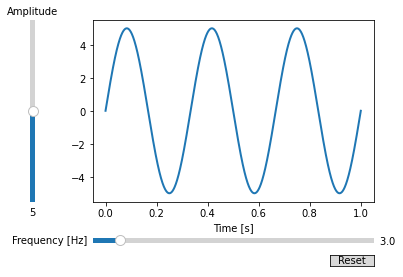

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button


# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = ax.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = fig.add_axes([0.25, 0.1, 0.65, 0.03])
freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = fig.add_axes([0.1, 0.25, 0.0225, 0.63])
amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

Now we're going to generate our first synthetic dataset.

In [8]:
data = []
for i in range(50):
    data.append(random_y_kx(sigma_noise=0.2))
    
x = []
y = []
for i in data:
    x.append(i[0][0])
    y.append(i[1][0])

In [9]:
def plot_xy(x, y, title=None, xlabel=None, ylabel=None):
    plt.plot(x, y, 'o')
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    plt.show()

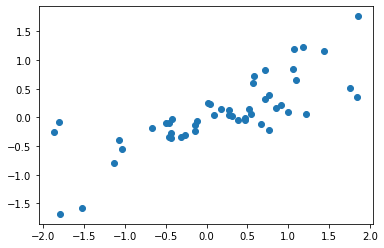

In [7]:
plot_xy(x, y)

We can take this one step further and model how our synthetic dataset changes when our noise is sampled from a different normal distribution.

In [10]:
def plot_sample(num_points=50, mean_noise=0, sigma_noise=1, size=1):
    data = []
    for i in range(num_points):
        data.append(random_y_kx(mean_noise=mean_noise, sigma_noise=sigma_noise, size=size)) 
    _x = []
    _y = []
    for i in data:
        _x.append(i[0][0])
        _y.append(i[1][0])

    plot_xy(_x, _y)

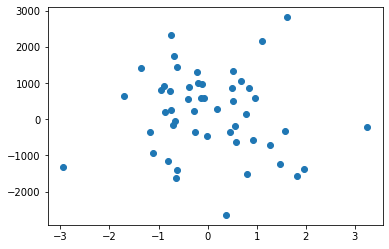

In [35]:
plot_sample(sigma_noise=1000)

Comment on the plot

## Modelling with Simulated Data

Describe the model we're going to use

In [36]:
model = LinearRegression()

model.fit(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))

LinearRegression()

In [38]:
r_sq = model.score(x_arr.reshape(-1, 1), y_arr.reshape(-1, 1))
print(f"coefficient of determination: {r_sq}")
print(f"intercept: {model.intercept_}")
print(f"slope: {model.coef_}")

coefficient of determination: 0.7240018728751738
intercept: [0.03469459]
slope: [[0.4505338]]


Comment on results

## Modelling with Real Data

Apply same model on real data

Comment on results

If you wish to get an overview of the remaining topics in this course, click the button below.

[![Back to main website](https://www.svgrepo.com/show/315449/enter.svg)](https://physdata.vercel.app/)